# Imitation Learning from Videos - Video Prediction Rewards (VIPER)
---

Imitation learning from videos is challenging as action labels are often not observed. A (autoregressive) video prediction model can  predict the next frame only based on the previous frames (and no explicit actions), i.e., $p_\theta(x_{t+1} | x_{t-k:t})$.

In this notebook, we aim to show examples of using such video prediction models for reward modelling in the DeepMind Control (DMC) environment. In particular, we consider the method described in [this paper](https://arxiv.org/pdf/2305.14343), called Video Prediction Rewards (VIPER). The main algorithm is as follows:

**Algorithm 1: VIPER**

Train video prediction model $ p_{\theta} $ on **expert videos**.

while *not converged* do

1. Choose action: $ a_t \sim \pi(x_t) $
2. Step environment: $ x_{t+1} \leftarrow \text{env}(a_t) $
3. Fill in reward: $ r_t \leftarrow \ln p_{\theta}(x_{t+1} \mid x_{t-k:t}) + \beta r_t^{\text{expl}} $
4. Add transition $ (x_t, a_t, r_t, x_{t+1}) $ to replay buffer.
5. Train $ \pi $ from replay buffer using any RL algorithm.

Most of this notebook is based on [these examples](https://github.com/Alescontrela/viper_rl/tree/main/notebooks).

## Visualizing Video Model Outputs

Rather than training the video prediction model from scratch, we load a model checkpoint trained on the expert videos in the DMC environment.

In [5]:
! wget -O checkpoint_dmc.sh https://raw.githubusercontent.com/Alescontrela/viper_rl/refs/heads/main/viper_rl_data/download/checkpoint_dmc.sh --quiet
! wget -O dataset_dmc.sh https://raw.githubusercontent.com/Alescontrela/viper_rl/refs/heads/main/viper_rl_data/download/dataset_dmc.sh --quiet
! python3 -m pip install internetarchive -q

In [6]:
# Download the dataset
! bash dataset_dmc.sh

Saving dataset to:
//datasets
dmc_dataset_aa:
 downloading dmc.tar.partaa: 100% 1.86G/1.86G [04:33<00:00, 7.32MiB/s]
dmc_dataset_ab:
 downloading dmc.tar.partab: 100% 1.86G/1.86G [04:04<00:00, 8.19MiB/s]
dmc_dataset_ac:
 downloading dmc.tar.partac: 100% 1.86G/1.86G [03:16<00:00, 10.2MiB/s]
dmc_dataset_ad:
 downloading dmc.tar.partad: 100% 1.86G/1.86G [04:56<00:00, 6.75MiB/s]
dmc_dataset_ae:
 downloading dmc.tar.partae: 100% 251M/251M [00:28<00:00, 9.17MiB/s]


In [2]:
# Download the model checkpoint
! bash checkpoint_dmc.sh

Saving checkpoint to:
//checkpoints
dmc_checkpoint_aa:
 downloading dmc.tar.partaa: 100% 677M/677M [01:18<00:00, 9.02MiB/s]


In [49]:
! git clone https://github.com/Alescontrela/viper_rl --quiet

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.append('viper_rl/viper_rl')
sys.path.append('viper_rl')

import imageio
from IPython.display import Image
import numpy as np

import notebooks.notebook_utils as nbu
from videogpt.reward_models.videogpt_reward_model import VideoGPTRewardModel

Let's first load the video prediction model.

In [3]:
reward_model = VideoGPTRewardModel(
    videogpt_path="/checkpoints/dmc_videogpt_l16_s1",
    vqgan_path="/checkpoints/dmc_vqgan",
    task='dmc_cheetah_run'
)

Reward model devices: cuda:0
Available tasks: ['acrobot_swingup', 'cartpole_balance', 'cartpole_swingup', 'cheetah_run', 'cup_catch', 'finger_spin', 'finger_turn_hard', 'hopper_stand', 'manipulator_bring_ball', 'pendulum_swingup', 'pointmass_easy', 'pointmass_hard', 'quadruped_run', 'quadruped_walk', 'reacher_easy']
Loaded conditioning information for task cheetah_run
finished loading VideoGPTRewardModel:
	seq_len: 16
	class_cond: True
	task: cheetah_run
	model: videogpt
	camera_key: image
	seq_len_steps: 16
	mask? False
	task_id: 3
	n_skip? 1


Now, we load sample sequences to serve as conditioning frames for the video model.

In [4]:
frames = np.load(open("/datasets/dmc/cheetah_run/test/20230308T073511-2fyNAhVrRMZG0Ej3OsMJNl-len1001-rew918.7.npz", "rb"))["arr_0"]
num_conditioning_frames = 10
init_frames = frames[:num_conditioning_frames][None, ...]

In [5]:
# Perform inference with the videogpt model.
frames = reward_model.rollout_video(init_frames, 90, seed=20, pbar=True, open_loop_ctx=num_conditioning_frames // reward_model.n_skip)

Latents of shape (16, 16)


100%|██████████| 12/12 [00:57<00:00,  4.77s/it]


We now visualize the predicted frames as follows:


Saved video to /tmp/test.gif


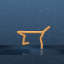

In [6]:
file = f'/tmp/test.gif'
image_list = [frames[0][j] for j in range(frames.shape[1])]
imageio.mimsave(file, image_list, duration=50, loop=0)
print(f'Saved video to {file}')
display(Image(data=open(file,'rb').read(), format='png', width=500, height=500))

## Using Pre-trained Video Models as Reward Functions

Here, we examine VIPER's effectiveness when used as a reward model. We will analyze the video model's log-likelihood to determine how correlated it is with the actual reward.


In [19]:
import glob
# directory of expert trajectories
dir_path = "/datasets/dmc/cheetah_run/test/"

trajs = glob.glob(dir_path + "*.npz")

likelihood_rewards = []
# only the first few frames
frame_num = 20
for traj in trajs:
    return_val = float(traj.split("rew")[-1].split(".npz")[0])
    frames = np.load(open(traj, "rb"))["arr_0"][:frame_num]
    seqs = [{"image": frames[i], "is_first": True if i == 0 else False} for i in range(frames.shape[0])]
    likelihoods = reward_model(seqs)
    likelihood = sum([l["density"].item() for l in likelihoods]) / len(likelihoods)
    likelihood_rewards.append((likelihood, return_val))


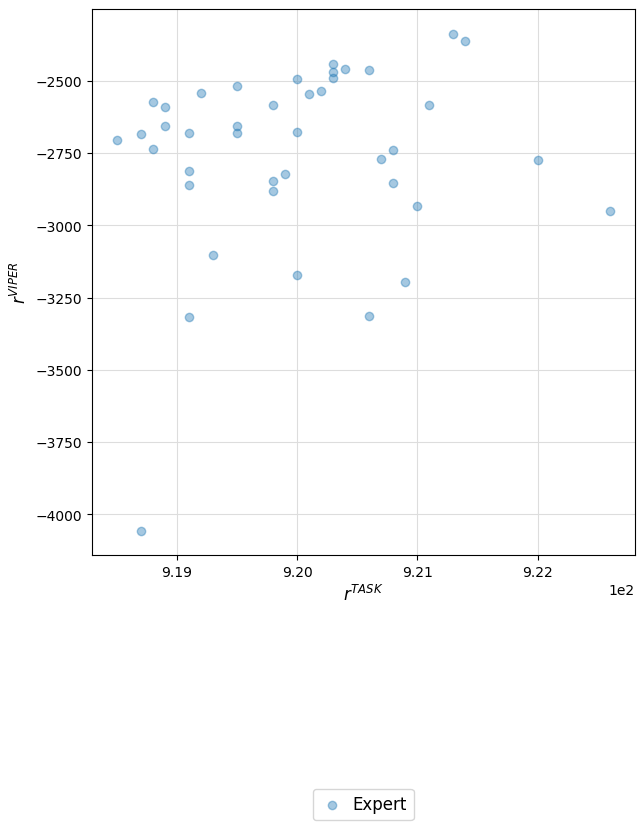

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

axes = axes.flatten()

rewards = [x[1] for x in likelihood_rewards]
densities = [x[0] for x in likelihood_rewards]

for ax in axes:
    ax.grid(which='both', color='#dddddd')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
    ax.tick_params(which='minor', length=0)

axes[0].scatter(rewards, densities, label='Expert', alpha=0.4, zorder=1000)
axes[0].set_xlabel(r'$r^{TASK}$', fontsize='large')
axes[0].set_ylabel(r'$r^{VIPER}$', fontsize='large')

options = dict(
    fontsize='large', numpoints=1, labelspacing=0, columnspacing=1.2,
    handlelength=1.5, handletextpad=0.5, ncol=4, loc='lower center', frameon=True, fancybox=True)
plt.legend(bbox_to_anchor=(0.5, -0.5), **options)
plt.ticklabel_format(axis='both', style='sci', scilimits=(2,4))
# plt.suptitle(f'Reward model: {rm_key}')
plt.subplots_adjust(bottom=0.1)
plt.show()